In [23]:
from pyomo.environ import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use({'figure.facecolor':'white'})

In [24]:
def read_input(filename):
    SystemDemand = pd.read_excel(filename, sheet_name = 'SystemDemand')
    PVGeneration = pd.read_excel(filename, sheet_name = 'PVGeneration')
    WindGeneration = pd.read_excel(filename, sheet_name = 'WindGeneration')
    Storage = pd.read_excel(filename, sheet_name='Storages')
    NodeData = pd.read_excel(filename, sheet_name='NodeData')
    LineData = pd.read_excel(filename, sheet_name='LineData')

    return {'SystemDemand':SystemDemand, 'PVGeneration':PVGeneration, 'WindGeneration':WindGeneration, \
            'Storage':Storage, 'NodeData':NodeData, 'LineData':LineData}

In [25]:
data = read_input(r'Input_Files\InputData34.xlsx')
for i in data.keys():
    print(i, ':\n', data[i])
    print('\n')

SystemDemand :
     TIME    PD    QD
0      1  1.00  1.00
1      2  1.20  1.20
2      3  1.40  1.40
3      4  0.80  0.80
4      5  0.70  0.70
5      6  1.30  1.30
6      7  1.40  1.40
7      8  1.50  1.50
8      9  1.70  1.70
9     10  1.10  1.10
10    11  0.50  0.50
11    12  0.30  0.30
12    13  0.50  0.50
13    14  0.70  0.70
14    15  1.00  1.00
15    16  1.40  1.40
16    17  1.70  1.70
17    18  1.92  1.92
18    19  1.95  1.95
19    20  1.10  1.10
20    21  1.00  1.00
21    22  0.80  0.80
22    23  0.50  0.50
23    24  0.20  0.20


PVGeneration :
     TIME   PPV  QPV
0      1  1.00    0
1      2  1.20    0
2      3  1.40    0
3      4  0.80    0
4      5  0.70    0
5      6  1.30    0
6      7  1.40    0
7      8  1.50    0
8      9  1.70    0
9     10  1.10    0
10    11  0.50    0
11    12  0.30    0
12    13  0.50    0
13    14  0.70    0
14    15  1.00    0
15    16  1.40    0
16    17  1.70    0
17    18  1.92    0
18    19  1.95    0
19    20  1.10    0
20    21  1.00    0
2

In [26]:
def optimization_model(inputData, Vmax, Vmin, Vnom, Sbase, Zbase):

    SystemDemand = inputData['SystemDemand']
    PVGeneration = inputData['PVGeneration']
    WindGeneration = inputData['WindGeneration']
    StorageData = inputData['Storage']
    NodeData = inputData['NodeData']
    LineData = inputData['LineData']
    time = [SystemDemand.loc[i, 'TIME'] for i in SystemDemand.index]
    lines = {(LineData.loc[i, 'FROM'], LineData.loc[i, 'TO']) for i in LineData.index}
    buses = [NodeData.loc[i, 'NODES'] for i in NodeData.index]
    storages = [StorageData.loc[i,'NODES'] for i in StorageData.index]
    R = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'R'] for i in LineData.index}
    X = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'X'] for i in LineData.index}
    B = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'B'] for i in LineData.index}
    Tb = {buses[i]:NodeData.loc[i, 'Tb'] for i in NodeData.index}
    Pd = {(buses[i], time[k]):NodeData.loc[i, 'PD']*SystemDemand.loc[k, 'PD']/Sbase for k in SystemDemand.index for i in NodeData.index}
    Qd = {(buses[i], time[k]):NodeData.loc[i, 'QD']*SystemDemand.loc[k, 'QD']/Sbase for k in SystemDemand.index for i in NodeData.index}
    Ppv = {(buses[i], time[k]):NodeData.loc[i, 'PPV']*PVGeneration.loc[k, 'PPV']/Sbase for k in PVGeneration.index for i in NodeData.index}
    Qpv = {(buses[i], time[k]):NodeData.loc[i, 'QPV']*PVGeneration.loc[k, 'QPV']/Sbase for k in PVGeneration.index for i in NodeData.index}
    Pwt = {(buses[i], time[k]):NodeData.loc[i, 'PWT']*WindGeneration.loc[k, 'PWT']/Sbase for k in WindGeneration.index for i in NodeData.index}
    Qwt = {(buses[i], time[k]):NodeData.loc[i, 'QWT']*WindGeneration.loc[k, 'QWT']/Sbase for k in WindGeneration.index for i in NodeData.index}
    ESS_Pmax = {storages[i]:StorageData.loc[i, 'Power']/Sbase for i in StorageData.index} #p.u.
    ESS_SOCmax = {storages[i]:StorageData.loc[i, 'Energy']/StorageData.loc[i, 'Energy']*100 for i in StorageData.index} #%
    ESS_SOCmin = {storages[i]:0 for i in StorageData.index} #%
    ESS_SOCini = {storages[i]:StorageData.loc[i, 'SOEini']/StorageData.loc[i, 'Energy']*100 for i in StorageData.index} #%
    ESS_Eff = {storages[i]:StorageData.loc[i, 'Eff'] for i in StorageData.index}
    ESS_SOEmax = {storages[i]:StorageData.loc[i, 'Energy'] for i in StorageData.index} #kWh

    #---------------------------------------------------------------------------------------------------------
    #Define the Model
    #---------------------------------------------------------------------------------------------------------

    model = ConcreteModel()

    #---------------------------------------------------------------------------------------------------------
    #Define Sets
    #---------------------------------------------------------------------------------------------------------
    model.LINES = Set(initialize=lines)
    model.NODES = Set(initialize=buses)
    model.TIME = Set(ordered=True, initialize=time)
    model.EES = Set(initialize=storages)

    #---------------------------------------------------------------------------------------------------------
    #Define Parameters
    #---------------------------------------------------------------------------------------------------------

    #Network
    model.R = Param(model.LINES, initialize=R, mutable=True, within=NonNegativeReals)
    model.X = Param(model.LINES, initialize=X, mutable=True, within=NonNegativeReals)
    model.B = Param(model.LINES, initialize=B, mutable=True, within=NonNegativeReals)
    model.Vmax = Param(initialize=Vmax, mutable=True) # p.u.
    model.Vmin = Param(initialize=Vmin, mutable=True) # p.u.
    model.Vnom = Param(initialize=1.0, mutable=True)  # p.u.

    #Load
    model.Pd = Param(model.NODES, model.TIME, initialize=Pd, mutable=True, within=Any)
    model.Qd = Param(model.NODES, model.TIME, initialize=Qd, mutable=True, within=Any)
    model.Tb = Param(model.NODES, initialize=Tb, mutable=True, within=Any)

    #PV generation
    model.Ppv = Param(model.NODES, model.TIME, initialize=Ppv, mutable=True, within=Any)
    model.Qpv = Param(model.NODES, model.TIME, initialize=Qpv, mutable=True, within=Any)

    #Wind generation
    model.Pwt = Param(model.NODES, model.TIME, initialize=Pwt, mutable=True, within=Any)
    model.Qwt = Param(model.NODES, model.TIME, initialize=Qwt, mutable=True, within=Any)

    #Energy storage system
    model.ESS_Pmax = Param(model.EES, initialize=ESS_Pmax, within=NonNegativeReals, mutable=True)
    model.ESS_SOCmax = Param(model.EES, initialize=ESS_SOCmax, within=NonNegativeReals, mutable=True)
    model.ESS_SOCmin = Param(model.EES, initialize=ESS_SOCmin, within=NonNegativeReals, mutable=True)
    model.ESS_SOCini = Param(model.EES, initialize=ESS_SOCini, within=NonNegativeReals, mutable=True)
    model.ESS_Eff = Param(model.EES, initialize=ESS_Eff, within=NonNegativeReals, mutable=True)
    model.ESS_SOEmax = Param(model.EES, initialize=ESS_SOEmax, within=NonNegativeReals, mutable=True)

    #---------------------------------------------------------------------------------------------------------
    #Initialize Parameters
    #---------------------------------------------------------------------------------------------------------

    def ini_resistance(model, i,j):
        return model.R[i,j]/Zbase
    model.RM = Param(model.LINES, rule=ini_resistance)  # p.u.
    def ini_reactance(model, i,j):
        return model.X[i,j]/Zbase
    model.XM = Param(model.LINES, rule=ini_reactance)   # p.u.
    def ini_susceptance(model, i,j):
        return model.B[i,j]
    model.BM = Param(model.LINES, rule=ini_susceptance) # p.u.

    #---------------------------------------------------------------------------------------------------------
    #Define Variables
    #---------------------------------------------------------------------------------------------------------

    #Network
    model.I = Var(model.LINES, model.TIME, initialize=0)
    model.P = Var(model.LINES, model.TIME, initialize=0)
    model.Q = Var(model.LINES, model.TIME, initialize=0)

    def ini_voltage(model, n, t):
        if model.Tb[n] == 0:
            temp = model.Vnom
            model.V[n,t].fixed = False
        else:
            temp = model.Vnom
            model.V[n,t].fixed = True
        return temp
    model.V = Var(model.NODES, model.TIME, initialize=ini_voltage)

    #Energy storage system
    model.Pch = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=0)
    model.Pdis = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=0)
    model.u_ess = Var(model.EES, model.TIME, within=Binary)

    def initial_SOC_rule(model, s, t):
        return model.ESS_SOCini[s].value
    model.SOC = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=initial_SOC_rule)

    #Supply
    def active_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Ps[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Ps = Var(model.NODES, model.TIME, initialize=active_supply_rule)

    def reactive_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Qs[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Qs = Var(model.NODES, model.TIME, initialize=reactive_supply_rule)

    #---------------------------------------------------------------------------------------------------------
    #Define Objective
    #---------------------------------------------------------------------------------------------------------

    def act_loss(model):
        return sum(model.RM[i,j]*(model.I[i,j,t]) for i,j in model.LINES for t in model.TIME)
    model.obj = Objective(rule=act_loss)

    #---------------------------------------------------------------------------------------------------------
    #Define Constraints
    #---------------------------------------------------------------------------------------------------------

    def active_power_flow_rule(model, k, t):
        # Power_in + Power_supplied = Power_out + Power_out_lost + Power_consumed
        return sum(model.P[i,j,t] for i,j in model.LINES if j == k) + model.Ps[k,t] + model.Ppv[k,t] + model.Pwt[k,t] + sum(model.Pdis[s,t] for s in model.EES if s == k) == \
               sum(model.P[i,j,t] + model.RM[i,j]*(model.I[i,j,t]) for i,j in model.LINES if i == k) + model.Pd[k,t] + sum(model.Pch[s,t] for s in model.EES if s == k)
    model.active_power_flow = Constraint(model.NODES, model.TIME, rule=active_power_flow_rule)

    def reactive_power_flow_rule(model, k, t):
        # Power_in + Power_supplied = Power_out + Power_out_lost + Power_consumed
        return sum(model.Q[i,j,t] + (model.V[j,t])*model.BM[i,j]/2 for i,j in model.LINES if j == k) + model.Qs[k,t] + model.Qpv[k,t] + model.Qwt[k,t] == \
               sum(model.Q[i,j,t] + model.XM[i,j]*(model.I[i,j,t]) - (model.V[i,t])*model.BM[i,j]/2 for i,j in model.LINES if i == k) + model.Qd[k,t]
    model.reactive_power_flow = Constraint(model.NODES, model.TIME, rule=reactive_power_flow_rule)

    def voltage_drop_rule(model, i, j, t):
        return (model.V[i,t]) - (model.V[j,t]) - 2*(model.RM[i,j]*model.P[i,j,t] + model.XM[i,j]*model.Q[i,j,t]) - (model.RM[i,j]**2 + model.XM[i,j]**2)*model.I[i,j,t] == 0
    model.voltage_drop = Constraint(model.LINES, model.TIME, rule=voltage_drop_rule)

    def define_current_rule(model, i, j, t):
        return (model.V[j,t])*(model.I[i,j,t]) >= (model.P[i,j,t]**2)+(model.Q[i,j,t]**2)
    model.define_current = Constraint(model.LINES, model.TIME, rule=define_current_rule)

    def voltage_limit_rule(model, n, t):
        return inequality(model.Vmin**2, model.V[n,t], model.Vmax**2)
    model.voltage_limit = Constraint(model.NODES, model.TIME, rule=voltage_limit_rule)

    def current_limit_rule(model, i, j, t):
        return 0 <= model.I[i,j,t]
    model.current_limit = Constraint(model.LINES, model.TIME, rule=current_limit_rule)

    def ESS_SOCupdate_rule(model, s, t):
        if model.TIME.ord(t) == 1:
            return model.SOC[s,t] == model.ESS_SOCini[s] + 100/model.ESS_SOEmax[s]*(model.ESS_Eff[s]*model.Pch[s,t]*Sbase - model.Pdis[s,t]*Sbase/model.ESS_Eff[s])
        if model.TIME.ord(t) > 1:
            return model.SOC[s,t] == model.SOC[s,model.TIME.prev(t)] + 100/model.ESS_SOEmax[s]*(model.ESS_Eff[s]*model.Pch[s,t]*Sbase - model.Pdis[s,t]*Sbase/model.ESS_Eff[s])
    model.EES_SOCupdate = Constraint(model.EES, model.TIME, rule=ESS_SOCupdate_rule)

    def ESS_SOClimit_rule(model, s, t):
        return inequality(model.ESS_SOCmin[s], model.SOC[s,t], model.ESS_SOCmax[s])
    model.ESS_SOClimit = Constraint(model.EES, model.TIME, rule=ESS_SOClimit_rule)

    def ESS_Charging_rule(model, s, t):
        return model.Pch[s,t] <= model.ESS_Pmax[s]*model.u_ess[s,t]
    model.ESS_Charging = Constraint(model.EES, model.TIME, rule=ESS_Charging_rule)

    def ESS_Discharging_rule(model, s, t):
        return model.Pdis[s,t] <= model.ESS_Pmax[s]*(1-model.u_ess[s,t])
    model.ESS_Discharging = Constraint(model.EES, model.TIME, rule=ESS_Discharging_rule)

    return model, buses, lines, storages

In [27]:
Sbase = 1000 # kVA
Vnom = 11/np.sqrt(3)    # kV
Zbase = (Vnom**2)*1000/Sbase # Ohm
Vmax = 1.05
Vmin = 0.7
model, buses, lines, storages = optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase)
#model.pprint()

In [28]:
solver = SolverFactory('gurobi')
solver.solve(model, tee=True)

Academic license - for non-commercial use only - expires 2021-03-26
Using license file C:\Users\filip\gurobi.lic
Read LP format model from file C:\Users\filip\AppData\Local\Temp\tmpofcqtnnp.pyomo.lp
Reading time = 0.04 seconds
x5017: 5089 rows, 3409 columns, 12479 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5089 rows, 3409 columns and 12479 nonzeros
Model fingerprint: 0x1f72c035
Model has 792 quadratic constraints
Variable types: 3361 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [2e-06, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e-03, 8e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+02]
Presolve removed 2691 rows and 171 columns
Presolve time: 0.40s
Presolved: 2398 rows, 3238 columns, 9474 nonzeros
Presolved model has 792 quadratic constraint(s)
Variable types: 3190 continuous, 48 integer (48 bina

{'Problem': [{'Name': 'x5017', 'Lower bound': 5.301002285788282, 'Upper bound': 5.30100228578829, 'Number of objectives': 1, 'Number of constraints': 5881, 'Number of variables': 3409, 'Number of binary variables': 48, 'Number of integer variables': 48, 'Number of continuous variables': 3361, 'Number of nonzeros': 12479, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '1.1387062072753906', 'Error rc': 0, 'Time': 1.3524706363677979}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [29]:
# CHECK LOSSES+DEMAND=SUPPLY
losses = value(model.obj)
supply = sum(sum(value(model.Ps[n, t]) + value(model.Ppv[n, t] + value(model.Pwt[n,t])) for n in model.NODES) + sum(value(model.Pdis[s, t]) for s in model.EES) for t in model.TIME)
demand = sum(sum(value(model.Pd[n, t]) for n in model.NODES) + sum(value(model.Pch[s, t]) for s in model.EES) for t in model.TIME)
print([supply, demand, losses])
print([supply*Sbase, demand*Sbase, losses*Sbase, demand*Sbase + losses*Sbase])

[73.96436955306862, 68.66336726728032, 5.301002285788287]
[73964.36955306862, 68663.36726728032, 5301.002285788287, 73964.36955306861]


In [30]:
# DATA VISUALIZATION - VOLTAGES AND ACTIVE/REACTIVE POWERS AND CURRENTS/LOADING OF LINES
voltage = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
loading = pd.DataFrame(columns=lines, index=data['SystemDemand']['TIME'].values)
active_d = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
reactive_d = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
active_s = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
reactive_s = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
active_pv = pd.DataFrame(columns=buses, index=data['PVGeneration']['TIME'].values)
active_wt = pd.DataFrame(columns=buses, index=data['WindGeneration']['TIME'].values)
reactive_wt = pd.DataFrame(columns=buses, index=data['WindGeneration']['TIME'].values)
SoC = pd.DataFrame(columns=storages, index=data['SystemDemand']['TIME'].values)
active_ch = pd.DataFrame(columns=storages, index=data['SystemDemand']['TIME'].values)
active_dis = pd.DataFrame(columns=storages, index=data['SystemDemand']['TIME'].values)
u_ess = pd.DataFrame(columns=storages, index=data['SystemDemand']['TIME'].values)

for t in model.TIME:
    for n in model.NODES:
        voltage.loc[t,n] = np.sqrt(model.V[n,t].value)
        active_d.loc[t,n] = model.Pd[n,t].value*Sbase
        reactive_d.loc[t,n] = model.Qd[n,t].value*Sbase
        active_s.loc[t,n] = model.Ps[n,t].value*Sbase
        reactive_s.loc[t,n] = model.Qs[n,t].value*Sbase
        active_pv.loc[t,n] = model.Ppv[n,t].value*Sbase
        active_wt.loc[t,n] = model.Pwt[n,t].value*Sbase
        reactive_wt.loc[t,n] = model.Qwt[n,t].value*Sbase
    for s in model.EES:
        SoC.loc[t,s] = model.SOC[s,t].value
        active_ch.loc[t,s] = model.Pch[s,t].value*Sbase
        active_dis.loc[t,s] = model.Pdis[s,t].value*Sbase
        u_ess.loc[t,s] = model.u_ess[s,t].value

for i,j in model.LINES:
    for t in model.TIME:
        loading.loc[t, pd.IndexSlice[i, j]] = np.sqrt(model.I[i,j,t].value)

In [31]:
for s in model.EES:
    print(model.ESS_SOCini[s].value)

4.081632653061225
36.231884057971016


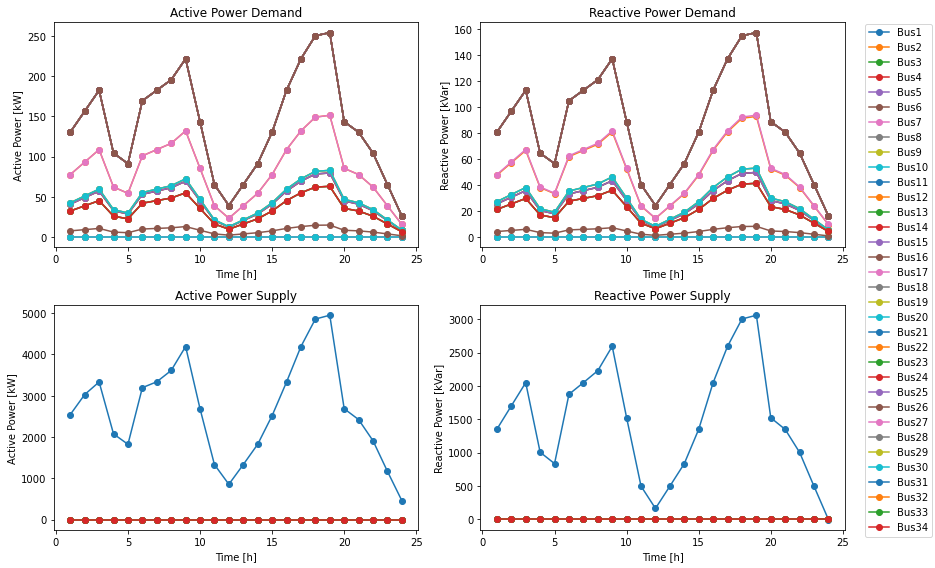

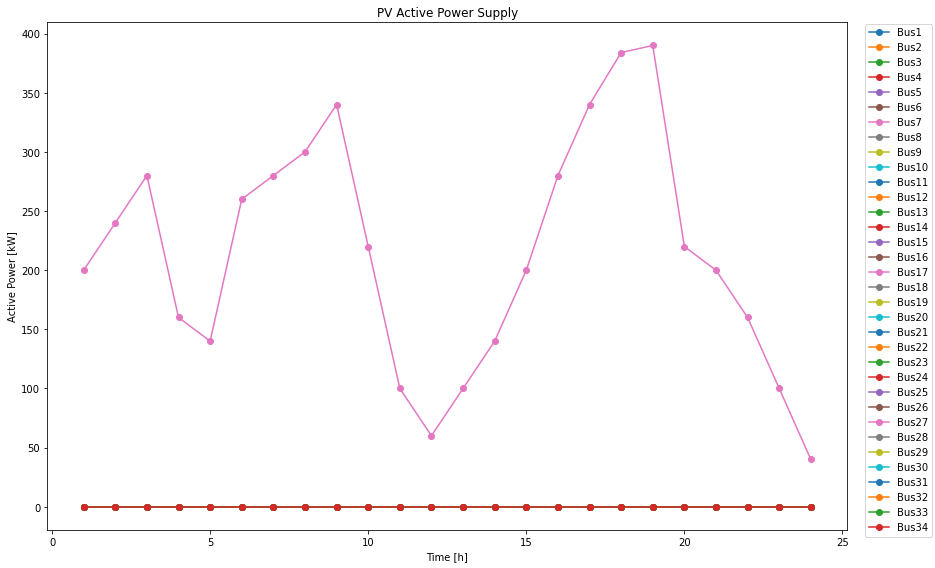

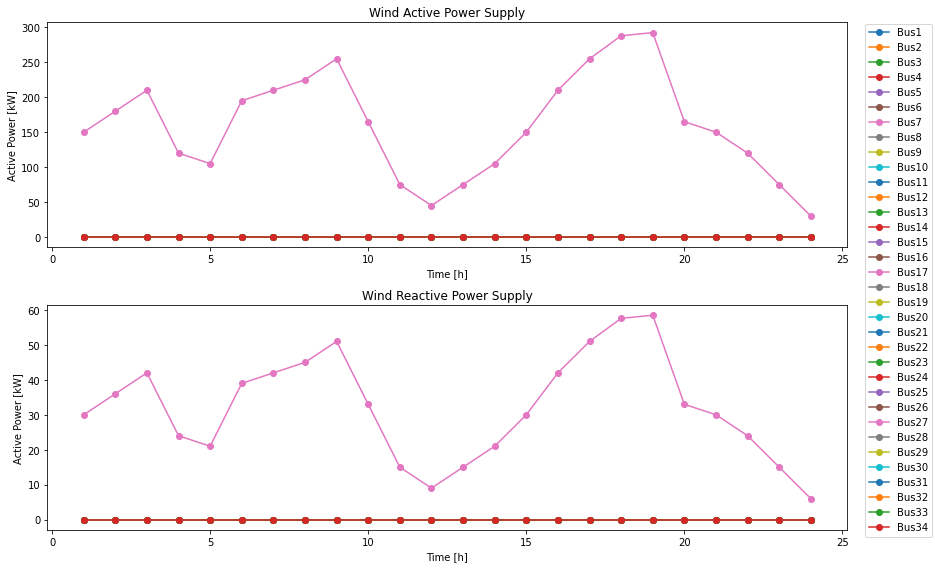

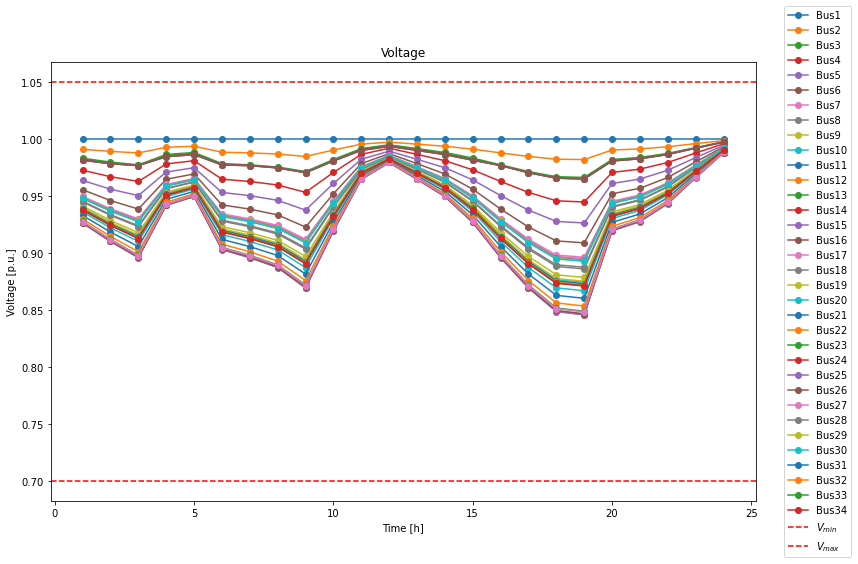

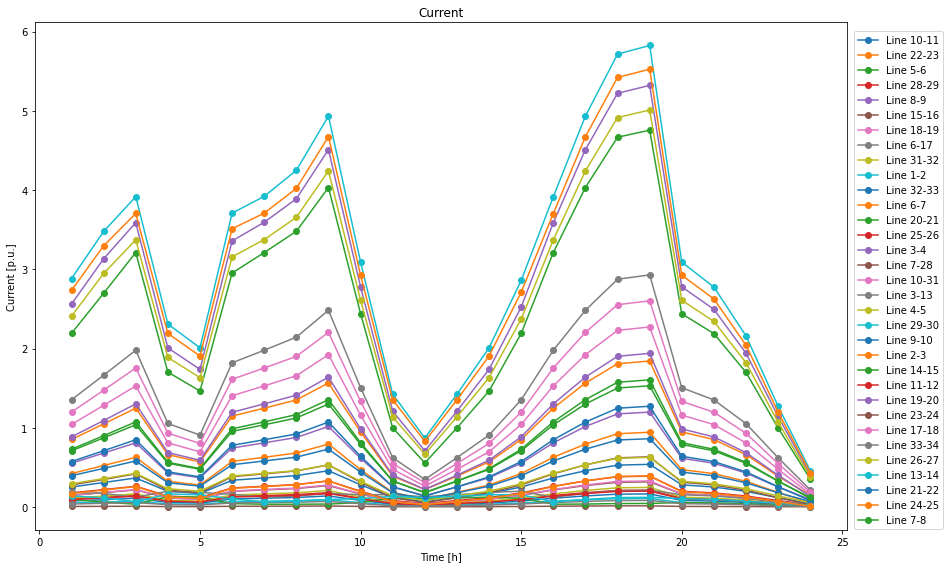

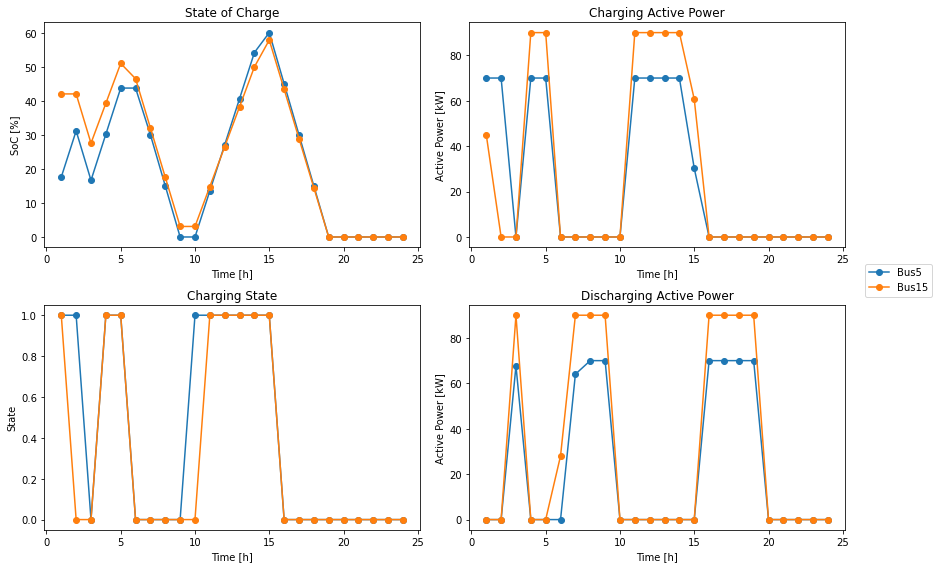

In [32]:
fig_pow, ax_pow = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
ax_pow[0,0].plot(active_d.index, active_d, marker='o');ax_pow[0,0].set_xlabel('Time [h]');ax_pow[0,0].set_ylabel('Active Power [kW]');ax_pow[0,0].set_title('Active Power Demand');
ax_pow[0,1].plot(reactive_d.index, reactive_d, marker='o');ax_pow[0,1].set_xlabel('Time [h]');ax_pow[0,1].set_ylabel('Reactive Power [kVar]');ax_pow[0,1].set_title('Reactive Power Demand');
ax_pow[1,0].plot(active_s.index, active_s, marker='o');ax_pow[1,0].set_xlabel('Time [h]');ax_pow[1,0].set_ylabel('Active Power [kW]');ax_pow[1,0].set_title('Active Power Supply');
ax_pow[1,1].plot(reactive_s.index, reactive_s, marker='o');ax_pow[1,1].set_xlabel('Time [h]');ax_pow[1,1].set_ylabel('Reactive Power [kVar]');ax_pow[1,1].set_title('Reactive Power Supply');
fig_pow.legend(['Bus'+str(i) for i in active_d.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_pow.tight_layout()
fig_pow.show;
plt.savefig('power.png', bbox_inches='tight')

fig_pv, ax_pv = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
ax_pv[0,0].plot(active_pv.index, active_pv, marker='o');ax_pv[0,0].set_xlabel('Time [h]');ax_pv[0,0].set_ylabel('Active Power [kW]');ax_pv[0,0].set_title('PV Active Power Supply');
fig_pv.legend(['Bus'+str(i) for i in active_pv.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_pv.tight_layout()
fig_pv.show;
plt.savefig('pv.png', bbox_inches='tight')

fig_wt, ax_wt = plt.subplots(nrows=2, ncols=1, squeeze=False, figsize=(12,8))
ax_wt[0,0].plot(active_wt.index, active_wt, marker='o');ax_wt[0,0].set_xlabel('Time [h]');ax_wt[0,0].set_ylabel('Active Power [kW]');ax_wt[0,0].set_title('Wind Active Power Supply');
ax_wt[1,0].plot(reactive_wt.index, reactive_wt, marker='o');ax_wt[1,0].set_xlabel('Time [h]');ax_wt[1,0].set_ylabel('Active Power [kW]');ax_wt[1,0].set_title('Wind Reactive Power Supply');
fig_wt.legend(['Bus'+str(i) for i in active_wt.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_wt.tight_layout()
fig_wt.show;
plt.savefig('wt.png', bbox_inches='tight')

b=['Bus'+str(i) for i in active_d.columns]
b.extend({'$V_{min}$','$V_{max}$'})
fig_v, ax_v = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
ax_v[0,0].plot(voltage.index, voltage, marker='o');ax_v[0,0].set_xlabel('Time [h]');ax_v[0,0].set_ylabel('Voltage [p.u.]');ax_v[0,0].set_title('Voltage');
ax_v[0,0].axhline(model.Vmin.value, color='r', linestyle='--')
ax_v[0,0].axhline(model.Vmax.value, color='r', linestyle='--')
ax_v[0,0].legend(b, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
fig_v.tight_layout()
fig_v.show;
plt.savefig('voltage.png', bbox_inches='tight')

fig_i, ax_i = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
ax_i[0,0].plot(loading.index, loading, marker='o');ax_i[0,0].set_xlabel('Time [h]');ax_i[0,0].set_ylabel('Current [p.u.]');ax_i[0,0].set_title('Current');
fig_i.legend(['Line '+str(i)+'-'+str(j) for i,j in loading.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_i.tight_layout()
fig_i.show;
plt.savefig('current.png', bbox_inches='tight')

# SOC
fig_ees, ax_ees = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
ax_ees[0,0].plot(SoC.index, SoC, marker='o');ax_ees[0,0].set_xlabel('Time [h]');ax_ees[0,0].set_ylabel('SoC [%]');ax_ees[0,0].set_title('State of Charge');
ax_ees[0,1].plot(active_ch.index, active_ch, marker='o');ax_ees[0,1].set_xlabel('Time [h]');ax_ees[0,1].set_ylabel('Active Power [kW]');ax_ees[0,1].set_title('Charging Active Power');
ax_ees[1,0].plot(u_ess.index, u_ess, marker='o');ax_ees[1,0].set_xlabel('Time [h]');ax_ees[1,0].set_ylabel('State');ax_ees[1,0].set_title('Charging State');
ax_ees[1,1].plot(active_dis.index, active_dis, marker='o');ax_ees[1,1].set_xlabel('Time [h]');ax_ees[1,1].set_ylabel('Active Power [kW]');ax_ees[1,1].set_title('Discharging Active Power');
fig_ees.legend(['Bus' + str(s) for s in SoC.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_ees.tight_layout()
fig_ees.show;
plt.savefig('ees.png', bbox_inches='tight')